In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

# Define functions

In [2]:
def merge(A, B, chrom):
        new_names_A = []
        new_names_B = []
        
        old_names_A = []
        old_names_B = []
        
        A.sort(key=lambda x: x[0])
        B.sort(key=lambda x: x[0])

        merged = []
        i = j = 0
        
        while i < len(A) and j < len(B):
            
            if (A[i][0] >= B[j][0] and A[i][0] <= B[j][1]) or (B[j][0] >= A[i][0] and B[j][0] <= A[i][1]):
                left = min(A[i][0], B[j][0])
                right = max(A[i][1], B[j][1])
                merged.append([left, right])
                new_names_A.append(f'{chrom}:{left}-{right}')
                new_names_B.append(f'{chrom}:{left}-{right}')
                old_names_A.append(f'{chrom}:{A[i][0]}-{A[i][1]}')
                old_names_B.append(f'{chrom}:{B[j][0]}-{B[j][1]}')
                i+=1 
                j+=1
            elif B[j][1] < A[i][0]:
                new_names_B.append('0') # '0' as a placeholder to be dropped later
                old_names_B.append(f'{chrom}:{B[j][0]}-{B[j][1]}')
                j+=1
            else:
                new_names_A.append('0')
                old_names_A.append(f'{chrom}:{A[i][0]}-{A[i][1]}')
                i+=1
        return new_names_A, new_names_B, old_names_A, old_names_B

In [3]:
def prepare_peaks(adata):
    peaks = {}
    
    for ch in set([name.split(':')[0] for name in adata.var_names]):
        peaks[ch] = []
        
    for name in adata.var_names:
        ch = name.split(":")[0]
        pos = name.split(":")[1].split('-')
        pos = [int(n) for n in pos]
        peaks[ch].append(pos)
        
    return peaks

In [4]:
def merge_and_rename_peaks(adata1, adata2, verbose=False):
    # create dict with peaks of format {'chr': [[peak1_start, peak1_end], ..., [peakn_start, peakn_end]], ...}
    peaks1 = prepare_peaks(adata1)
    peaks2 = prepare_peaks(adata2)
    
    # find chromosomes present in both adatas
    common_chrs = peaks1.keys() & peaks2.keys()
    
    # find new peak intervals
    adata1_new_var_names = []
    adata2_new_var_names = []

    adata1_old_var_names = []
    adata2_old_var_names = []

    for chrom in common_chrs:
        if verbose:
            print(f'Processing chromosome {chrom}...')
        
        new_names1, new_names2, old_names1, old_names2 = merge(peaks1[chrom], peaks2[chrom], chrom)
        
        adata1_new_var_names.extend(new_names1)
        adata2_new_var_names.extend(new_names2)
        
        adata1_old_var_names.extend(old_names1)
        adata2_old_var_names.extend(old_names2)
    
    # create dataframes with new var names
    df1 = pd.DataFrame(list(zip(adata1_old_var_names, adata1_new_var_names)), columns=['old_var_names', 'new_var_names'])
    df1 = df1.set_index('old_var_names')
    
    df2 = pd.DataFrame(list(zip(adata2_old_var_names, adata2_new_var_names)), columns=['old_var_names', 'new_var_names'])
    df2 = df2.set_index('old_var_names')
    
    # fill chromosomes that were not in the common set with '0'
    df1 = pd.DataFrame(index=adata1.var_names).join(df1).fillna('0')
    df2 = pd.DataFrame(index=adata2.var_names).join(df2).fillna('0')

    # join new var names with adata.var
    adata1.var = adata1.var.join(df1[['new_var_names']])
    adata2.var = adata2.var.join(df2[['new_var_names']])
    
    # drop peaks with '0'
    adata1 = adata1[:, adata1.var['new_var_names'] != '0']
    adata2 = adata2[:, adata2.var['new_var_names'] != '0']
    
    # rename the peaks
    adata1.var_names = adata1.var['new_var_names']
    adata2.var_names = adata2.var['new_var_names']
    
    del adata1.var['new_var_names']
    del adata2.var['new_var_names']
    
    return adata1, adata2

# Load data

In [5]:
scrna1 = sc.read('../data/new-data-2020/expressions.h5ad')
scrna1

AnnData object with n_obs × n_vars = 2859 × 22955
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'count'

In [6]:
scatac1 = sc.read('../data/new-data-2020/peaks.h5ad')
scatac1

AnnData object with n_obs × n_vars = 2859 × 62657
    obs: 'nb_features', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'
    layers: 'binary'

In [7]:
scrna2 = sc.read('../data/new-data-2020/expressions-2.h5ad')
scrna2

AnnData object with n_obs × n_vars = 3475 × 23305
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'count'

In [8]:
scatac2 = sc.read('../data/new-data-2020/peaks-2.h5ad')
scatac2

AnnData object with n_obs × n_vars = 3475 × 62834
    obs: 'nb_features', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'
    layers: 'binary'

In [9]:
scrna3 = sc.read('../data/10xpbmc10k-2020/expressions-raw.h5ad')
scrna3

AnnData object with n_obs × n_vars = 10025 × 25604
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [10]:
scrna3.layers['count'] = scrna3.X
sc.pp.normalize_total(scrna3, target_sum=1e4)
sc.pp.log1p(scrna3)
scrna3

AnnData object with n_obs × n_vars = 10025 × 25604
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'count'

In [11]:
scatac3 = sc.read('../data/10xpbmc10k-2020/peaks.h5ad')
scatac3

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type'
    layers: 'binary'

# Merge ATAC-seq datasets

In [12]:
adata1, adata2 = merge_and_rename_peaks(scatac1, scatac2)

/home/icb/anastasia.litinetskaya/miniconda3/envs/mofa/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
adata1, adata3 = merge_and_rename_peaks(adata1, scatac3)

In [14]:
adata2, adata3 = merge_and_rename_peaks(adata2, adata3)

In [15]:
adata1

AnnData object with n_obs × n_vars = 2859 × 38238
    obs: 'nb_features', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'
    layers: 'binary'

In [16]:
adata2

AnnData object with n_obs × n_vars = 3475 × 38238
    obs: 'nb_features', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'
    layers: 'binary'

In [17]:
adata3

AnnData object with n_obs × n_vars = 10000 × 38238
    obs: 'cell_type'
    layers: 'binary'

In [18]:
atac = adata1.concatenate(adata2, adata3, batch_key='concat_key')
atac

AnnData object with n_obs × n_vars = 16334 × 38238
    obs: 'nb_features', 'cell_type', 'concat_key'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'commonness-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'commonness-1'
    layers: 'binary'

In [19]:
atac.X = atac.layers['binary']
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)

In [20]:
sc.pp.neighbors(atac)
sc.tl.umap(atac)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [34]:
atac.obs['batch'] = atac.obs['concat_key'].cat.rename_categories(['Sagner-1', 'Sagner-2', '10x-PBMCs-10k'])

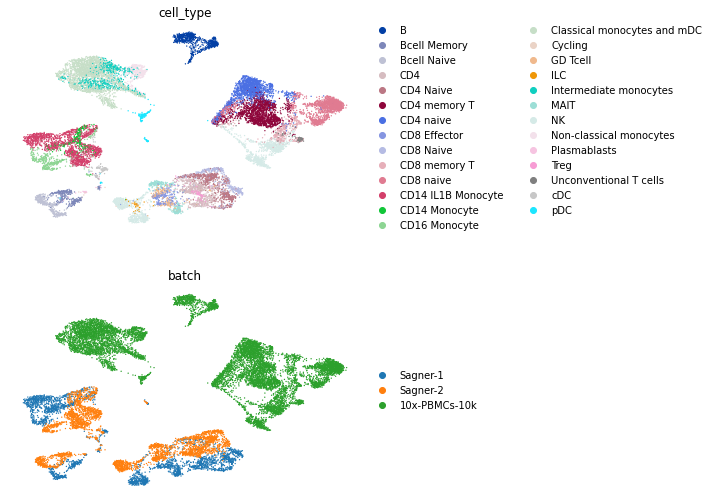

In [35]:
sc.pl.umap(atac, color=['cell_type', 'batch'], ncols=1, frameon=False)

# Merge RNA-seq datasets

In [22]:
scrna1

AnnData object with n_obs × n_vars = 2859 × 22955
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'count'

In [23]:
scrna2

AnnData object with n_obs × n_vars = 3475 × 23305
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'count'

In [24]:
scrna3 = scrna3[scatac3.obs_names]
scrna3.obs = scrna3.obs.join(scatac3.obs[['cell_type']], lsuffix='_old')
scrna3

/home/icb/anastasia.litinetskaya/miniconda3/envs/mofa/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 10000 × 25604
    obs: 'cell_type_old', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'count'

In [25]:
scrna = scrna1.concatenate(scrna2, scrna3, batch_key='concat_key')
scrna

AnnData object with n_obs × n_vars = 16334 × 21621
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'cell_type_old', 'concat_key'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2'
    layers: 'count'

In [26]:
scrna.X = scrna.layers['count']
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

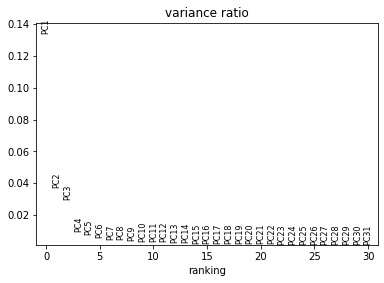

In [27]:
sc.pp.highly_variable_genes(scrna)
sc.tl.pca(scrna, random_state=0, svd_solver='arpack', n_comps=50)
sc.pl.pca_variance_ratio(scrna)

In [28]:
sc.pp.neighbors(scrna, n_pcs=10)
sc.tl.umap(scrna)

In [32]:
scrna.obs['batch'] = scrna.obs['concat_key'].cat.rename_categories(['Sagner-1', 'Sagner-2', '10x-PBMCs-10k'])

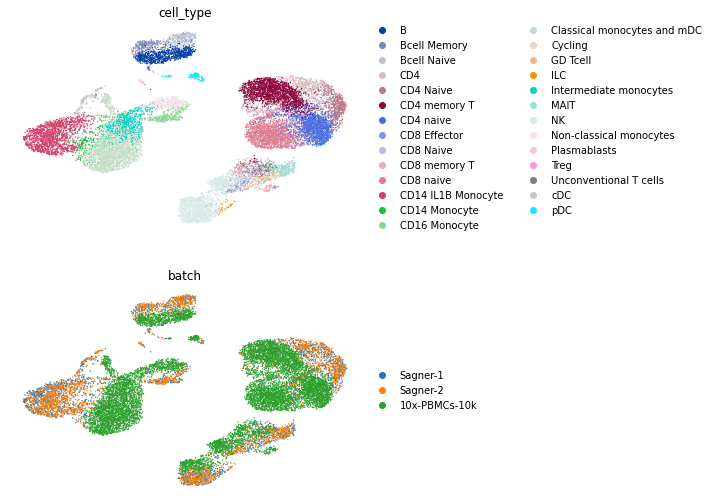

In [33]:
sc.pl.umap(scrna, color=['cell_type', 'batch'], ncols=1, frameon=False)